In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
with open('gdrive/My Drive/ML/x_data-1.npy', 'rb') as f:

    x_data = np.load(f)

In [4]:
x_data=x_data[:20500]

In [5]:

x_data.shape

(20500, 32, 32, 3)

In [6]:
y_data = np.ones((20500, 1), dtype=int)*9

## Setup

In [7]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [8]:
num_classes = 15 #initially 10
input_shape = (32,32,3)

#classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classes = [str(i) for i in range(num_classes)]
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14']

## Define hyperparameters

In [9]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 7  # Number of clusters. 20 here
k_neighbours = 10  # Number of neighbours to consider during cluster learning. Initially 5
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

## Implement data preprocessing

The data preprocessing step resizes the input images to the desired `target_size` and applies
feature-wise normalization. Note that, when using `keras.applications.ResNet50V2` as the
visual encoder, resizing the images into 255 x 255 inputs would lead to more accurate results
but require a longer time to train.

In [10]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)

## Data augmentation

Unlike simCLR, which randomly picks a single data augmentation function to apply to an input
image, we apply a set of data augmentation functions randomly to the input image.
(You can experiment with other image augmentation techniques by following the [data augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).)

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.001, 0.001), width_factor=(-0.001, 0.001), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(
            factor=0.25, fill_mode="nearest"
        ),
        layers.RandomZoom(
            height_factor=(-0.001, 0.001), width_factor=(-0.001, 0.001), fill_mode="nearest"
        )
    ]
)

Display a random image

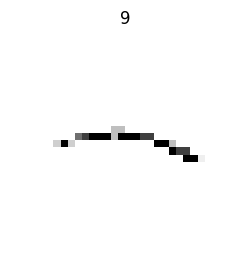

In [12]:
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")

Display a sample of augmented versions of the image

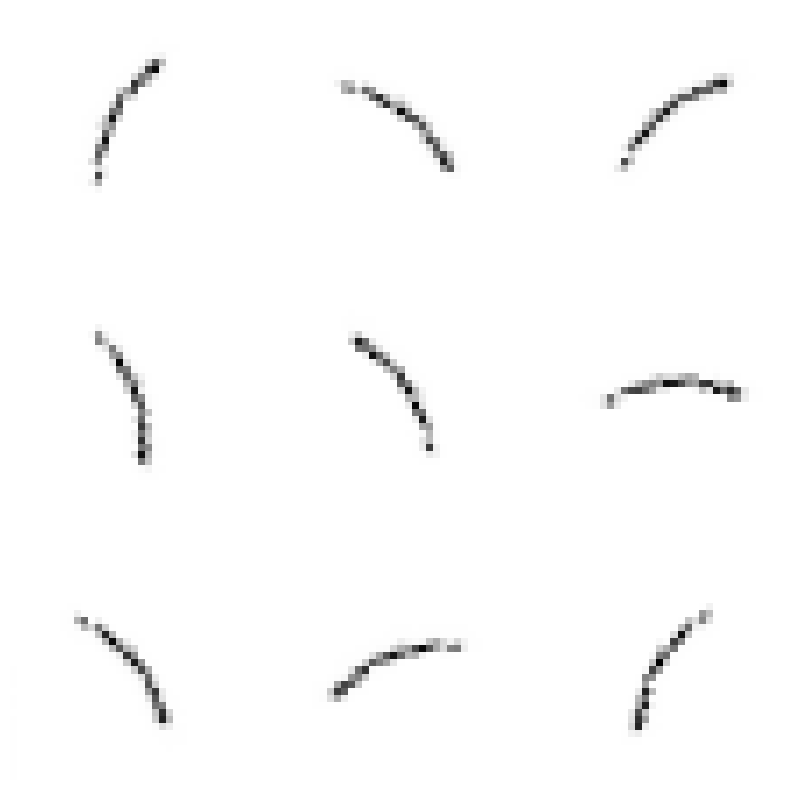

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Self-supervised representation learning

### Implement the vision encoder

In [14]:

def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder


### Implement the unsupervised contrastive loss

In [15]:

class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Train the model

In [16]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=50,  # for better results, increase the number of epochs to 500.
)


Epoch 1/50
41/41 [==============================] - 51s 341ms/step - loss: 56.7429
Epoch 2/50
41/41 [==============================] - 12s 302ms/step - loss: 12.7339
Epoch 3/50
41/41 [==============================] - 12s 300ms/step - loss: 11.8877
Epoch 4/50
41/41 [==============================] - 12s 296ms/step - loss: 11.2179
Epoch 5/50
41/41 [==============================] - 12s 294ms/step - loss: 10.7510
Epoch 6/50
41/41 [==============================] - 12s 293ms/step - loss: 10.4254
Epoch 7/50
41/41 [==============================] - 12s 294ms/step - loss: 10.2380
Epoch 8/50
41/41 [==============================] - 12s 295ms/step - loss: 10.0259
Epoch 9/50
41/41 [==============================] - 12s 296ms/step - loss: 9.8590
Epoch 10/50
41/41 [==============================] - 12s 296ms/step - loss: 9.8183
Epoch 11/50
41/41 [==============================] - 12s 295ms/step - loss: 9.7215
Epoch 12/50
41/41 [==============================] - 12s 295ms/step - loss: 9.6270
Epoch

Plot training loss

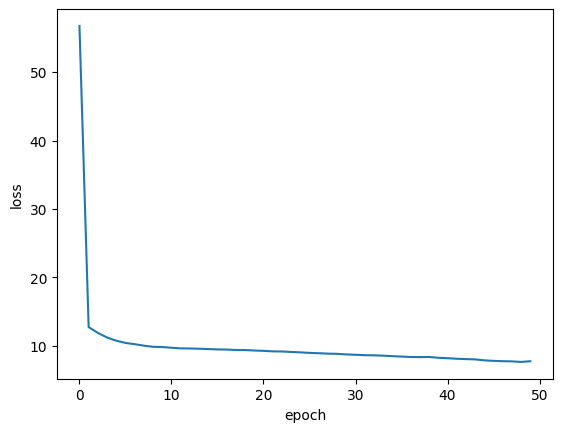

In [17]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Compute the nearest neighbors

### Generate the embeddings for the images

In [18]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

41/41 [==============================] - 3s 32ms/step


### Find the *k* nearest neighbours for each embedding

In [19]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 41/41 [00:00<00:00, 219.84it/s]


Let's display some neighbors on each row

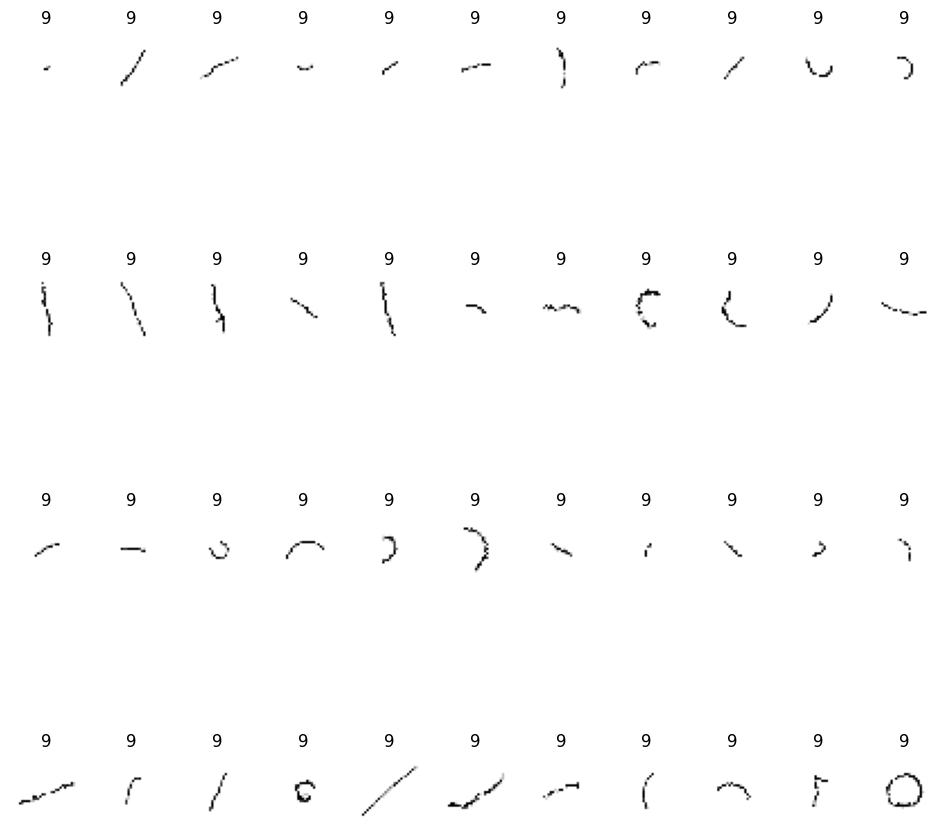

In [20]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis("off")
        position += 1

You notice that images on each row are visually similar, and belong to similar classes.

## Semantic clustering with nearest neighbours

### Implement clustering consistency loss

This loss tries to make sure that neighbours have the same clustering assignments.

In [21]:

class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super(ClustersConsistencyLoss, self).__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)


### Implement the clusters entropy loss

This loss tries to make sure that cluster distribution is roughly uniformed, to avoid
assigning most of the instances to one cluster.

In [22]:

class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super(ClustersEntropyLoss, self).__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss


### Implement clustering model

This model takes a raw image as an input, generated its feature vector using the trained
encoder, and produces a probability distribution of the clusters given the feature vector
as the cluster assignments.

In [23]:

def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model


### Implement clustering learner

This model receives the input `anchor` image and its `neighbours`, produces the clusters
assignments for them using the `clustering_model`, and produces two outputs:
1. `similarity`: the similarity between the cluster assignments of the `anchor` image and
its `neighbours`. This output is fed to the `ClustersConsistencyLoss`.
2. `anchor_clustering`: cluster assignments of the `anchor` images. This is fed to the `ClustersEntropyLoss`.

In [24]:

def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model


### Train model

In [25]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = tf.ones(shape=(x_data.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=50)

Epoch 1/50
41/41 [==============================] - 33s 450ms/step - loss: 0.6269 - similarity_loss: 0.6233 - clustering_loss: 0.0036
Epoch 2/50
41/41 [==============================] - 17s 404ms/step - loss: 0.6231 - similarity_loss: 0.6227 - clustering_loss: 3.9158e-04
Epoch 3/50
41/41 [==============================] - 16s 395ms/step - loss: 0.6193 - similarity_loss: 0.6185 - clustering_loss: 7.9885e-04
Epoch 4/50
41/41 [==============================] - 16s 394ms/step - loss: 0.6156 - similarity_loss: 0.6141 - clustering_loss: 0.0015
Epoch 5/50
41/41 [==============================] - 16s 400ms/step - loss: 0.6140 - similarity_loss: 0.6123 - clustering_loss: 0.0018
Epoch 6/50
41/41 [==============================] - 17s 404ms/step - loss: 0.6125 - similarity_loss: 0.6111 - clustering_loss: 0.0014
Epoch 7/50
41/41 [==============================] - 17s 403ms/step - loss: 0.6119 - similarity_loss: 0.6102 - clustering_loss: 0.0017
Epoch 8/50
41/41 [==============================] - 16

Plot training loss

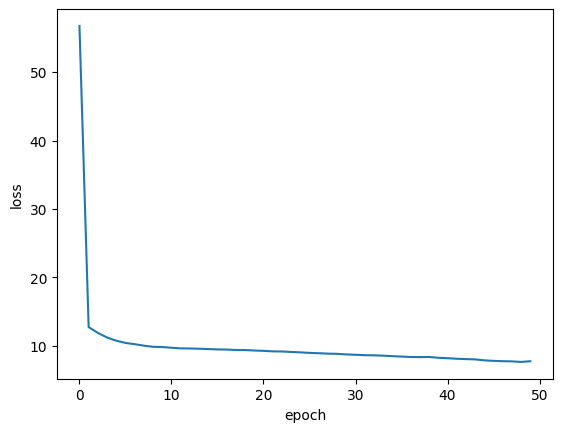

In [26]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Cluster analysis

### Assign images to clusters

In [27]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

41/41 [==============================] - 2s 35ms/step


Let's compute the cluster sizes

In [28]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 2229
cluster 1 : 2093
cluster 2 : 3347
cluster 3 : 3655
cluster 4 : 3190
cluster 5 : 2776
cluster 6 : 3210


Notice that the clusters have roughly balanced sizes.

### Visualize cluster images

Display the *prototypes*—instances with the highest clustering confidence—of each cluster:

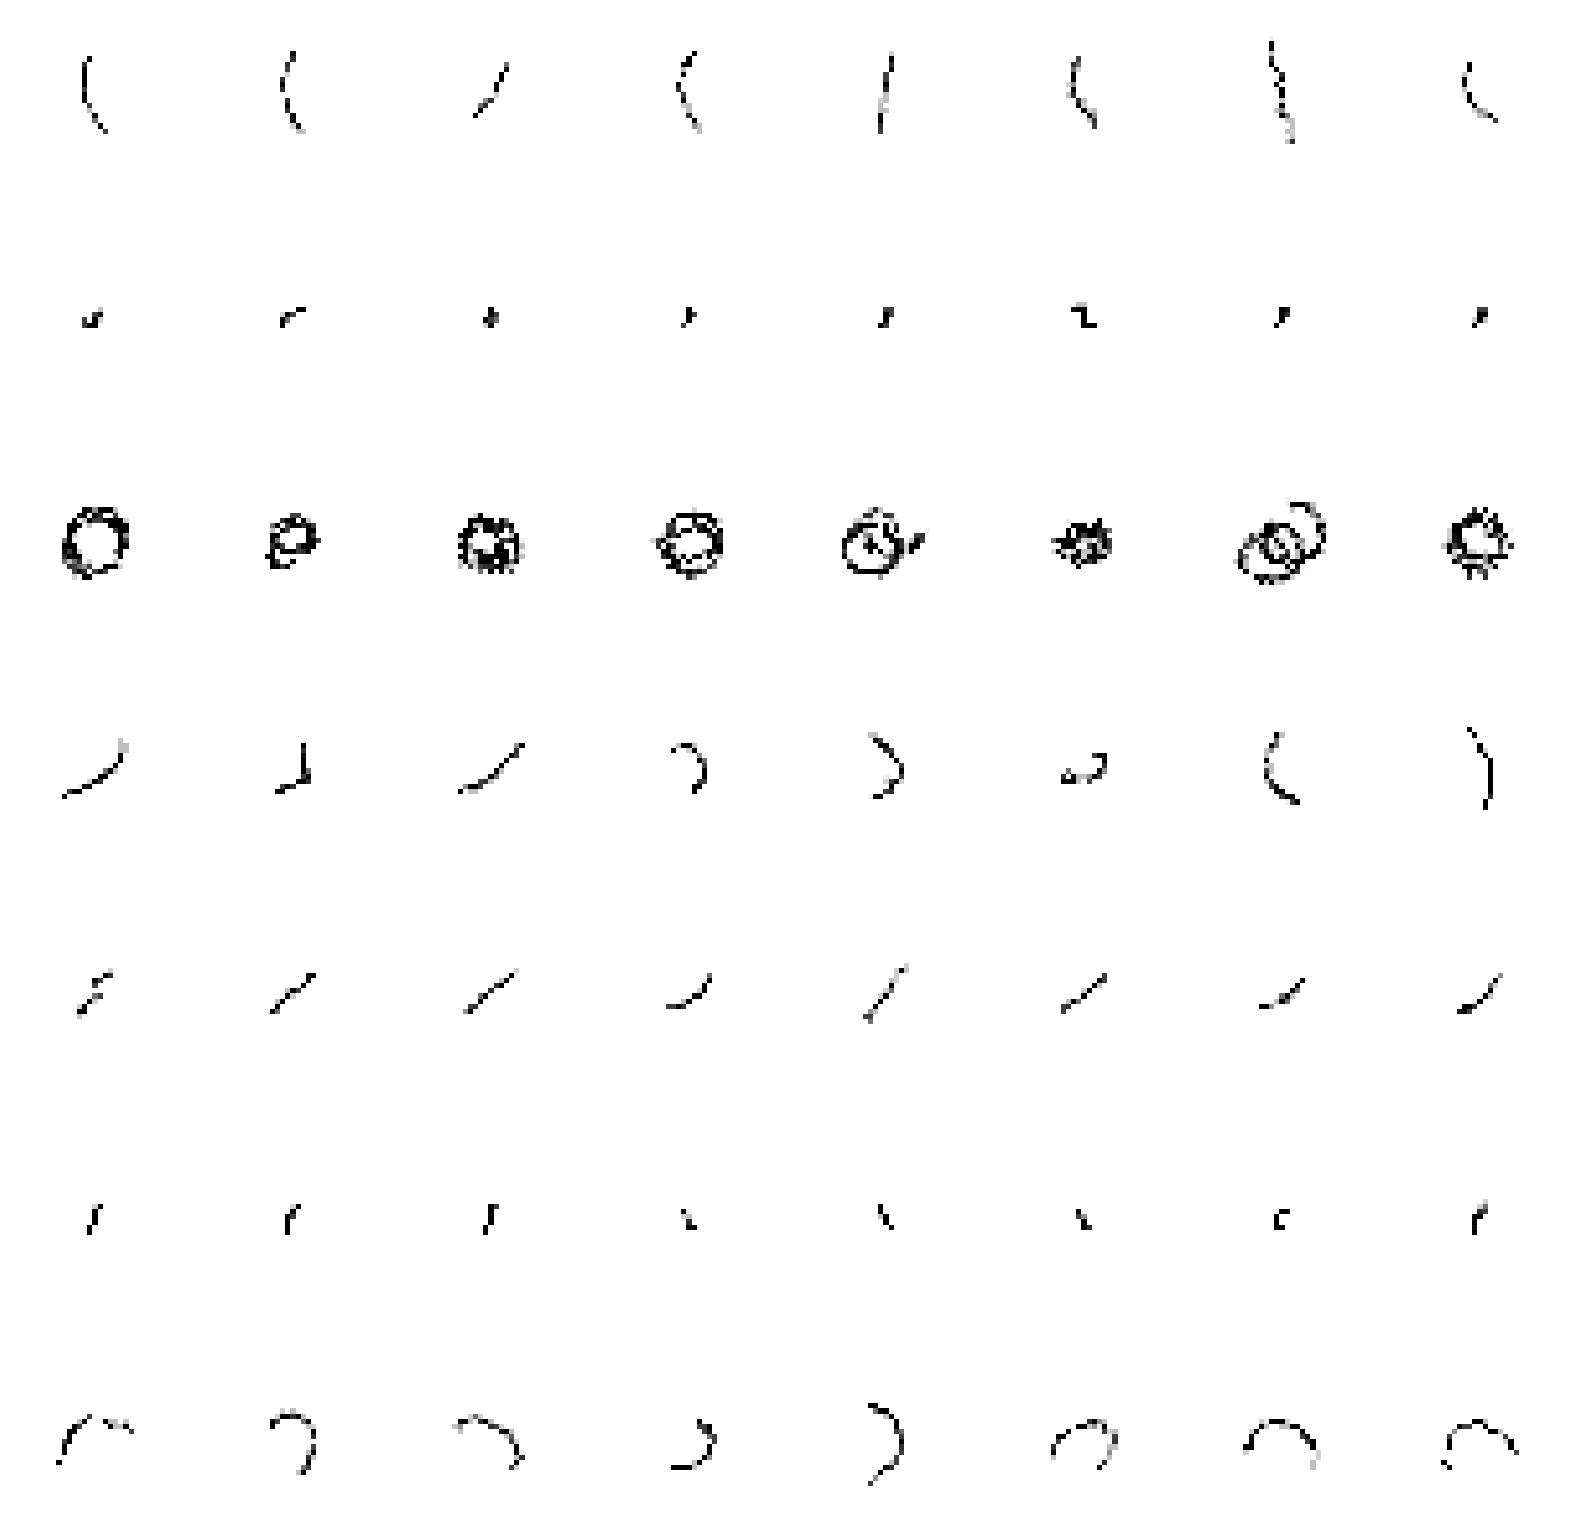

In [29]:
num_images = 8
plt.figure(figsize=(20, 20))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        #plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1

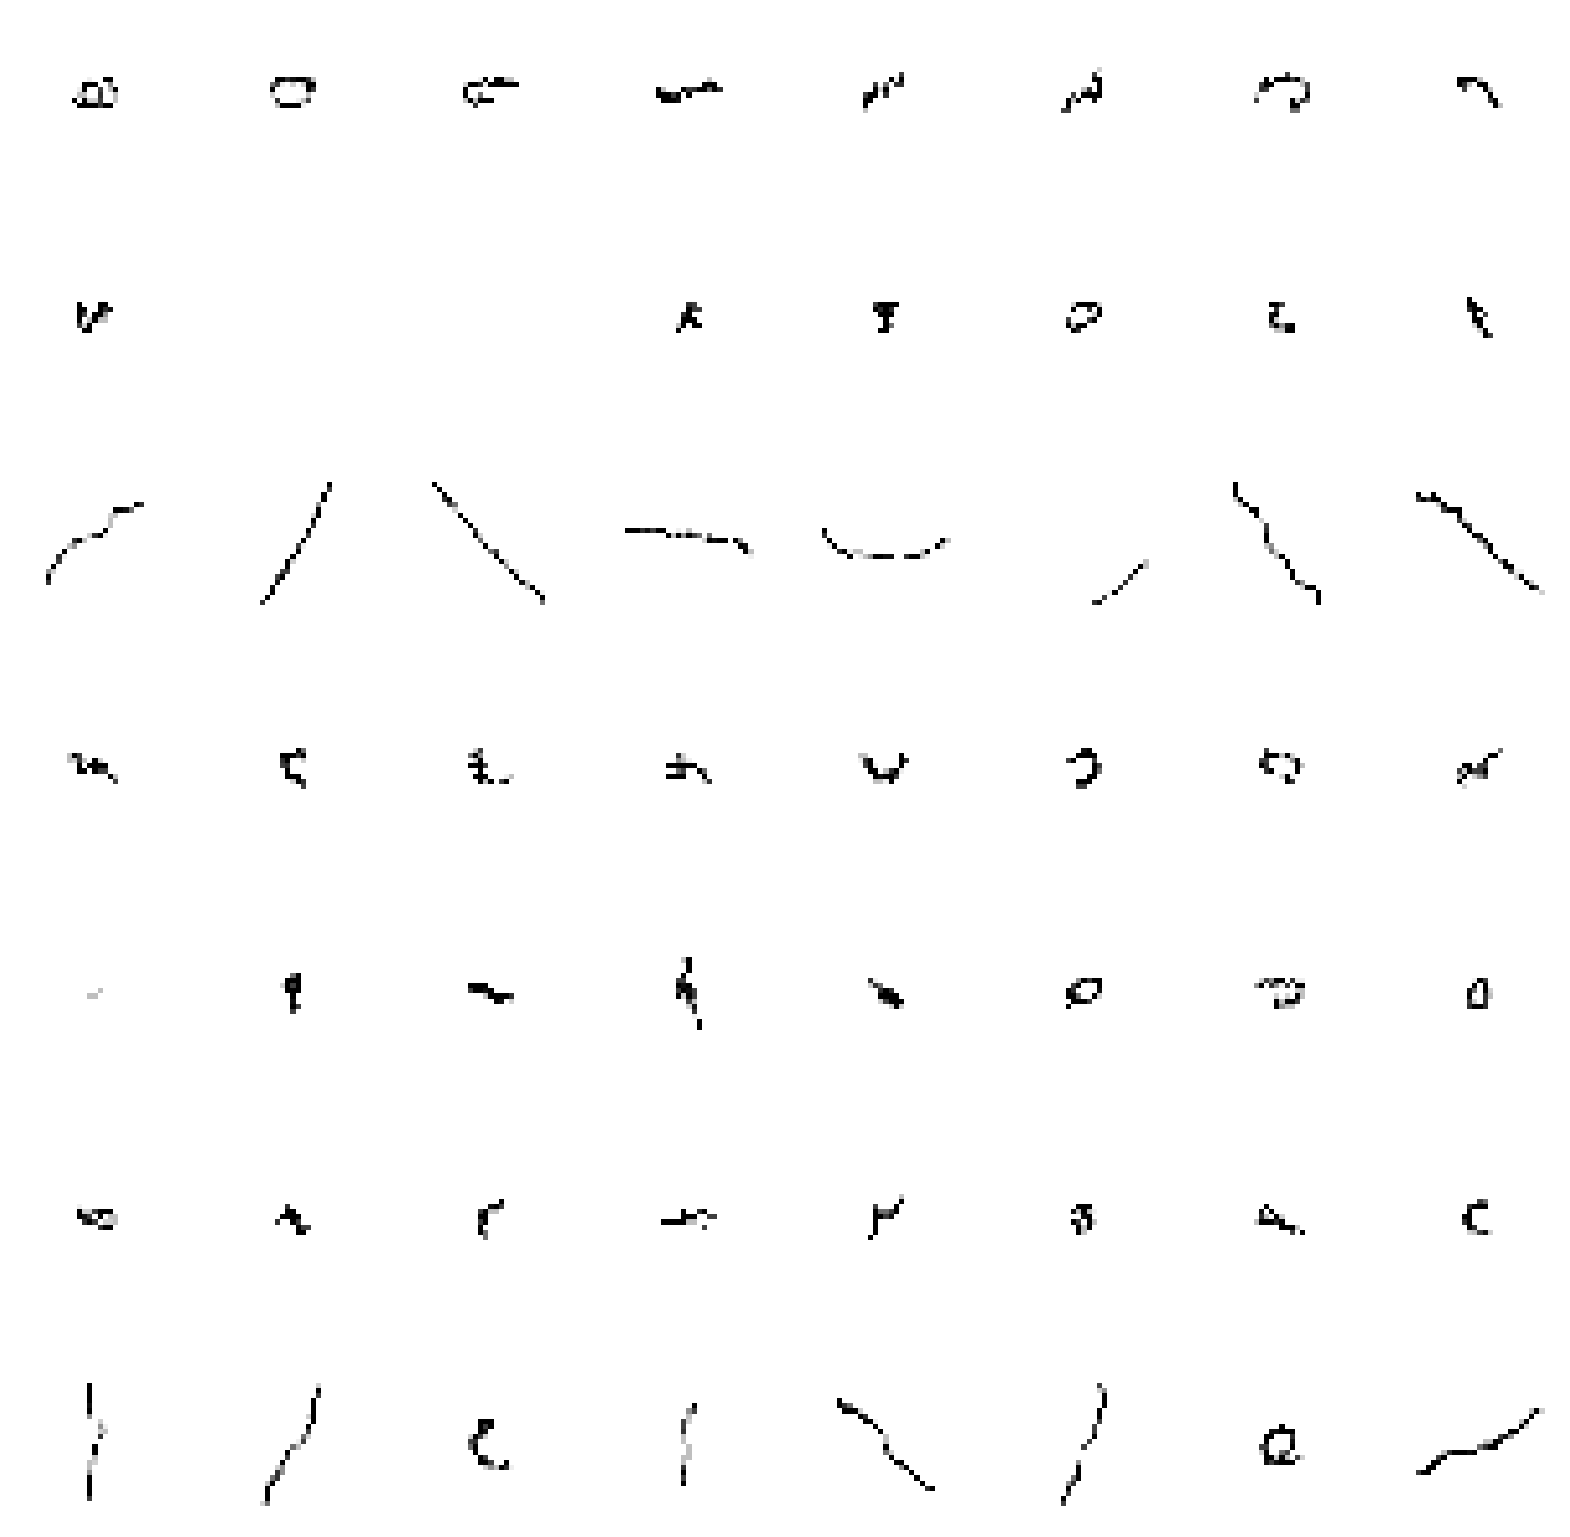

In [30]:
num_images = 8
plt.figure(figsize=(20, 20))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=False)

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        #plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1

In [ ]:
print(type(clusters))

<class 'collections.defaultdict'>


In [ ]:
import pickle 
with open("/content/sample_data/clusters.pkl", "wb") as pkl_handle:
	pickle.dump(clusters, pkl_handle)

In [ ]:
with open("clusters.pkl", "rb") as pkl_handle:
	clusters_copy = pickle.load(pkl_handle)

In [ ]:
import pickle 

with open("/content/sample_data/x_data-20500.pkl", "wb") as pkl_handle:
	pickle.dump(x_data, pkl_handle)

In [ ]:
with open("x_data-20500.pkl", "rb") as pkl_handle:
	x_data_copy = pickle.load(pkl_handle)